# Stroke Prediction: Complete Machine Learning Analysis

## Objective
Build a robust machine learning pipeline to predict patient stroke risk using healthcare data. This analysis demonstrates deep clinical understanding, model interpretability, and rigorous evaluation.

## Key Challenge
Severe Class Imbalance (approx. 95% Healthy vs. 5% Stroke)

## Clinical Goal
Maximize Sensitivity (Recall) to detect strokes while monitoring Specificity to avoid alarm fatigue.


In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, average_precision_score,
                             brier_score_loss, matthews_corrcoef)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import shap
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")
print("Plots directory created/verified: plots/")


Libraries imported successfully!


## 1. Data Loading and Initial Inspection


In [5]:
# Load the dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (5110, 12)

Column names: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

First few rows:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
# Check data types and missing values
print("Data Info:")
print(df.info())
print("\n" + "="*50)
print("\nMissing values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nBasic statistics:")
df.describe()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


Missing values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## 2. Data Cleaning & Advanced Preprocessing

### 2.1 Initial Cleaning


In [7]:
# Drop the id column (not useful for prediction)
df_clean = df.drop('id', axis=1)

# Check for and remove duplicate rows
duplicates_before = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_before}")
df_clean = df_clean.drop_duplicates()
print(f"Dataset shape after removing duplicates: {df_clean.shape}")

# Check target distribution
print(f"\nTarget distribution:")
print(df_clean['stroke'].value_counts())
print(f"\nTarget distribution (percentage):")
print(df_clean['stroke'].value_counts(normalize=True) * 100)


Number of duplicate rows: 0
Dataset shape after removing duplicates: (5110, 11)

Target distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

Target distribution (percentage):
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


### 2.2 Missing Value Imputation with KNNImputer

**Why KNNImputer?** Unlike simple mean/median imputation, KNNImputer uses the k-nearest neighbors to estimate missing values. This preserves relationships between features and provides more accurate imputations, especially important for clinical data where BMI might correlate with age, glucose levels, and other health indicators.


In [8]:
# Check missing values in bmi
print(f"Missing BMI values: {df_clean['bmi'].isnull().sum()}")
print(f"BMI column type: {df_clean['bmi'].dtype}")

# Convert bmi to numeric (handling 'N/A' strings)
df_clean['bmi'] = pd.to_numeric(df_clean['bmi'], errors='coerce')

# Prepare numerical columns for KNNImputer
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
print(f"\nMissing values before imputation:")
print(df_clean[numerical_cols].isnull().sum())

# Apply KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_clean[numerical_cols] = imputer.fit_transform(df_clean[numerical_cols])

print(f"\nMissing values after KNNImputer:")
print(df_clean[numerical_cols].isnull().sum())


Missing BMI values: 201
BMI column type: float64

Missing values before imputation:
age                    0
avg_glucose_level      0
bmi                  201
dtype: int64

Missing values after KNNImputer:
age                  0
avg_glucose_level    0
bmi                  0
dtype: int64


### 2.3 Outlier Handling with Winsorization

**Why Winsorization?** Instead of deleting outliers (which could remove legitimate stroke cases), we cap extreme values at the 1st and 99th percentiles. This preserves data while reducing the impact of extreme outliers on model training.


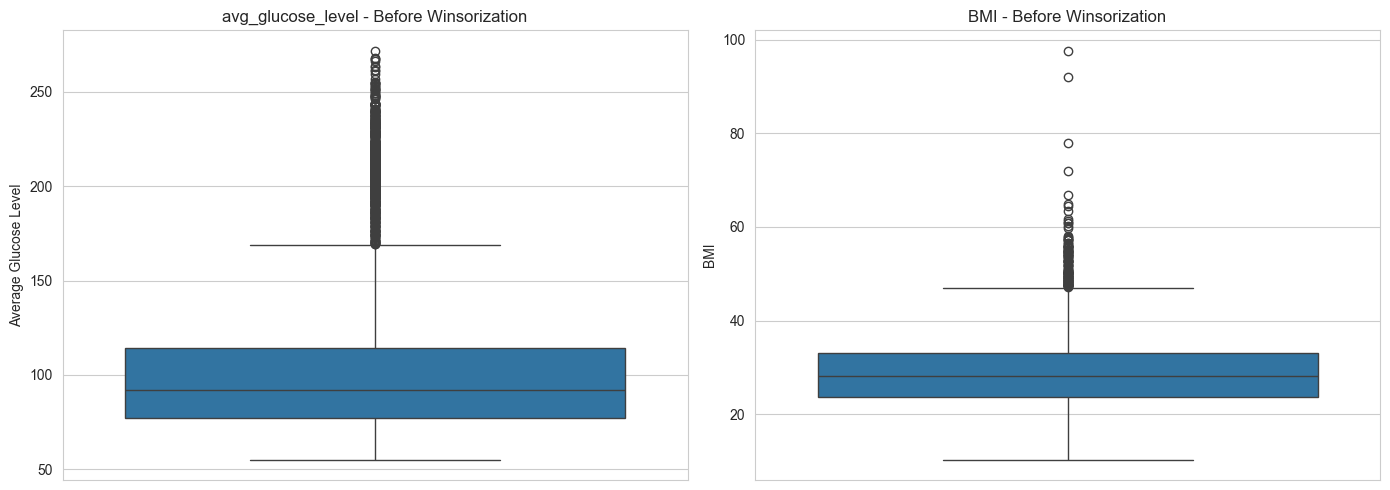

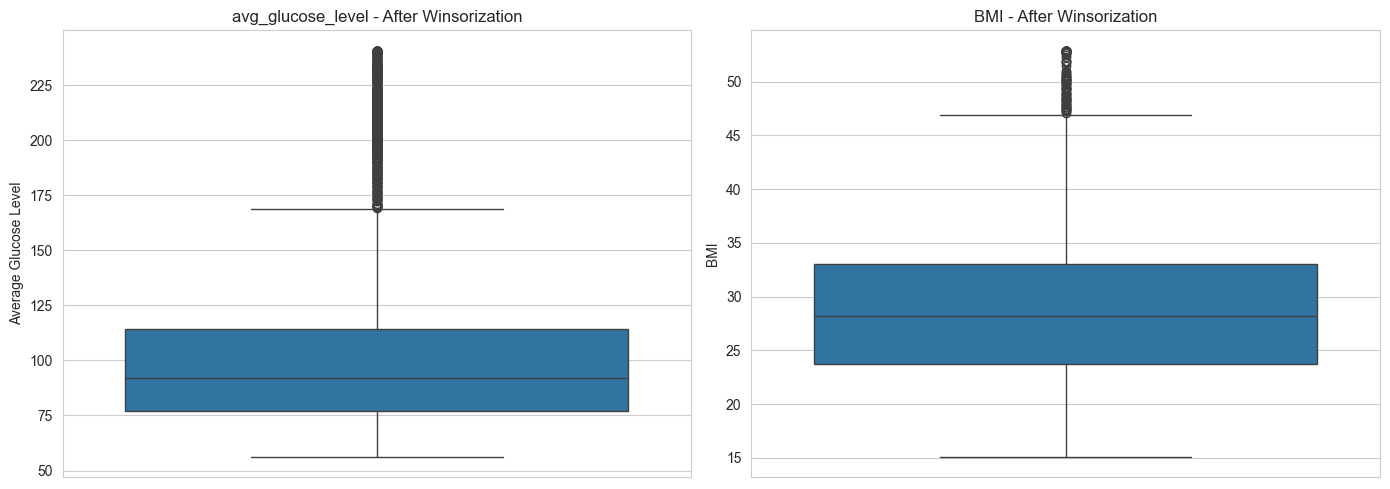

Winsorization completed!


In [ ]:
# Visualize outliers before treatment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(y=df_clean['avg_glucose_level'], ax=axes[0])
axes[0].set_title('avg_glucose_level - Before Winsorization')
axes[0].set_ylabel('Average Glucose Level')

sns.boxplot(y=df_clean['bmi'], ax=axes[1])
axes[1].set_title('BMI - Before Winsorization')
axes[1].set_ylabel('BMI')

plt.tight_layout()
plt.savefig('plots/03_outliers_before_winsorization.png', dpi=300, bbox_inches='tight')
plt.show()

# Apply Winsorization (capping at 1st and 99th percentiles)
def winsorize(series, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = series.quantile(lower_percentile)
    upper_bound = series.quantile(upper_percentile)
    return series.clip(lower=lower_bound, upper=upper_bound)

df_clean['avg_glucose_level'] = winsorize(df_clean['avg_glucose_level'])
df_clean['bmi'] = winsorize(df_clean['bmi'])

# Visualize after Winsorization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(y=df_clean['avg_glucose_level'], ax=axes[0])
axes[0].set_title('avg_glucose_level - After Winsorization')
axes[0].set_ylabel('Average Glucose Level')

sns.boxplot(y=df_clean['bmi'], ax=axes[1])
axes[1].set_title('BMI - After Winsorization')
axes[1].set_ylabel('BMI')

plt.tight_layout()
plt.savefig('plots/04_outliers_after_winsorization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Winsorization completed!")


### 2.4 Feature Engineering


In [10]:
# Create Age_Group feature
def categorize_age(age):
    if age < 45:
        return 'Young'
    elif age < 65:
        return 'Middle'
    else:
        return 'Senior'

df_clean['Age_Group'] = df_clean['age'].apply(categorize_age)

# Create BMI_Category feature
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df_clean['BMI_Category'] = df_clean['bmi'].apply(categorize_bmi)

# Create Risk_Factor_Count (sum of hypertension + heart_disease)
df_clean['Risk_Factor_Count'] = df_clean['hypertension'] + df_clean['heart_disease']

print("Feature engineering completed!")
print(f"\nAge_Group distribution:")
print(df_clean['Age_Group'].value_counts())
print(f"\nBMI_Category distribution:")
print(df_clean['BMI_Category'].value_counts())
print(f"\nRisk_Factor_Count distribution:")
print(df_clean['Risk_Factor_Count'].value_counts())


Feature engineering completed!

Age_Group distribution:
Age_Group
Young     2533
Middle    1550
Senior    1027
Name: count, dtype: int64

BMI_Category distribution:
BMI_Category
Obese          2028
Overweight     1480
Normal         1261
Underweight     341
Name: count, dtype: int64

Risk_Factor_Count distribution:
Risk_Factor_Count
0    4400
1     646
2      64
Name: count, dtype: int64


### 2.5 Encoding Categorical Variables


In [11]:
# Separate features and target
X = df_clean.drop('stroke', axis=1)
y = df_clean['stroke']

# Identify categorical and numerical columns
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 
                    'smoking_status', 'Age_Group', 'BMI_Category']
binary_cols = ['hypertension', 'heart_disease']
numerical_cols = ['age', 'avg_glucose_level', 'bmi', 'Risk_Factor_Count']

# Apply OneHotEncoder to categorical variables
ohe = OneHotEncoder(drop='first', sparse_output=False)
X_categorical = ohe.fit_transform(X[categorical_cols])
feature_names_categorical = ohe.get_feature_names_out(categorical_cols)

# Create DataFrame with encoded categorical features
X_encoded = pd.DataFrame(X_categorical, columns=feature_names_categorical, index=X.index)

# Add binary and numerical columns
X_encoded = pd.concat([X_encoded, X[binary_cols + numerical_cols]], axis=1)

print(f"Shape after encoding: {X_encoded.shape}")
print(f"\nFeature names: {X_encoded.columns.tolist()}")
X_encoded.head()


Shape after encoding: (5110, 22)

Feature names: ['gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'Age_Group_Senior', 'Age_Group_Young', 'BMI_Category_Obese', 'BMI_Category_Overweight', 'BMI_Category_Underweight', 'hypertension', 'heart_disease', 'age', 'avg_glucose_level', 'bmi', 'Risk_Factor_Count']


,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,...,Age_Group_Young,BMI_Category_Obese,BMI_Category_Overweight,BMI_Category_Underweight,hypertension,heart_disease,age,avg_glucose_level,bmi,Risk_Factor_Count
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0,1,67.0,228.69,36.60,1
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0,0,61.0,202.21,31.38,0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0,1,80.0,105.92,32.50,1
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0,0,49.0,171.23,34.40,0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1,0,79.0,174.12,24.00,1


## 3. Statistical Exploratory Data Analysis (EDA)

### 3.1 Target Distribution Visualization


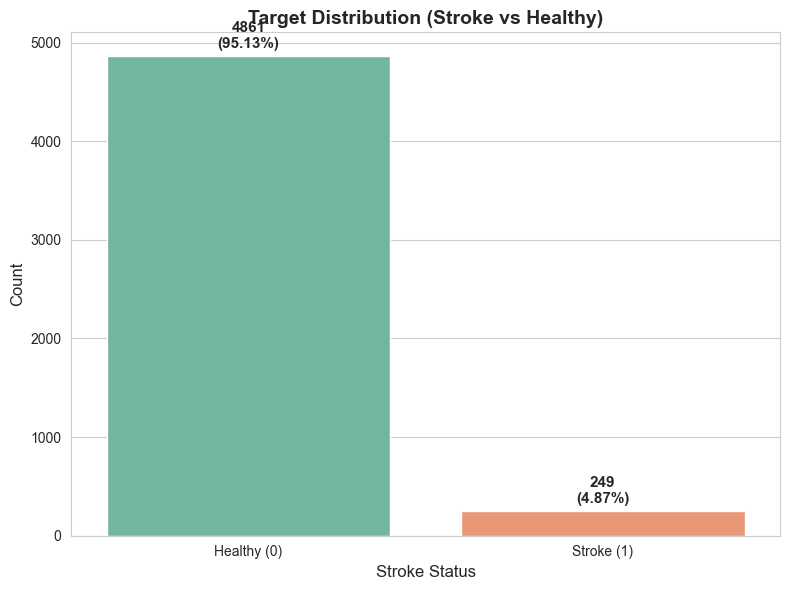

In [ ]:
# Target distribution countplot with percentages
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_clean, x='stroke', palette='Set2')
ax.set_xlabel('Stroke Status', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Target Distribution (Stroke vs Healthy)', fontsize=14, fontweight='bold')
ax.set_xticklabels(['Healthy (0)', 'Stroke (1)'])

# Add percentage annotations
total = len(df_clean)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width()/2., height + 50,
            f'{int(height)}\n({percentage:.2f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


### 3.2 Correlation Heatmap


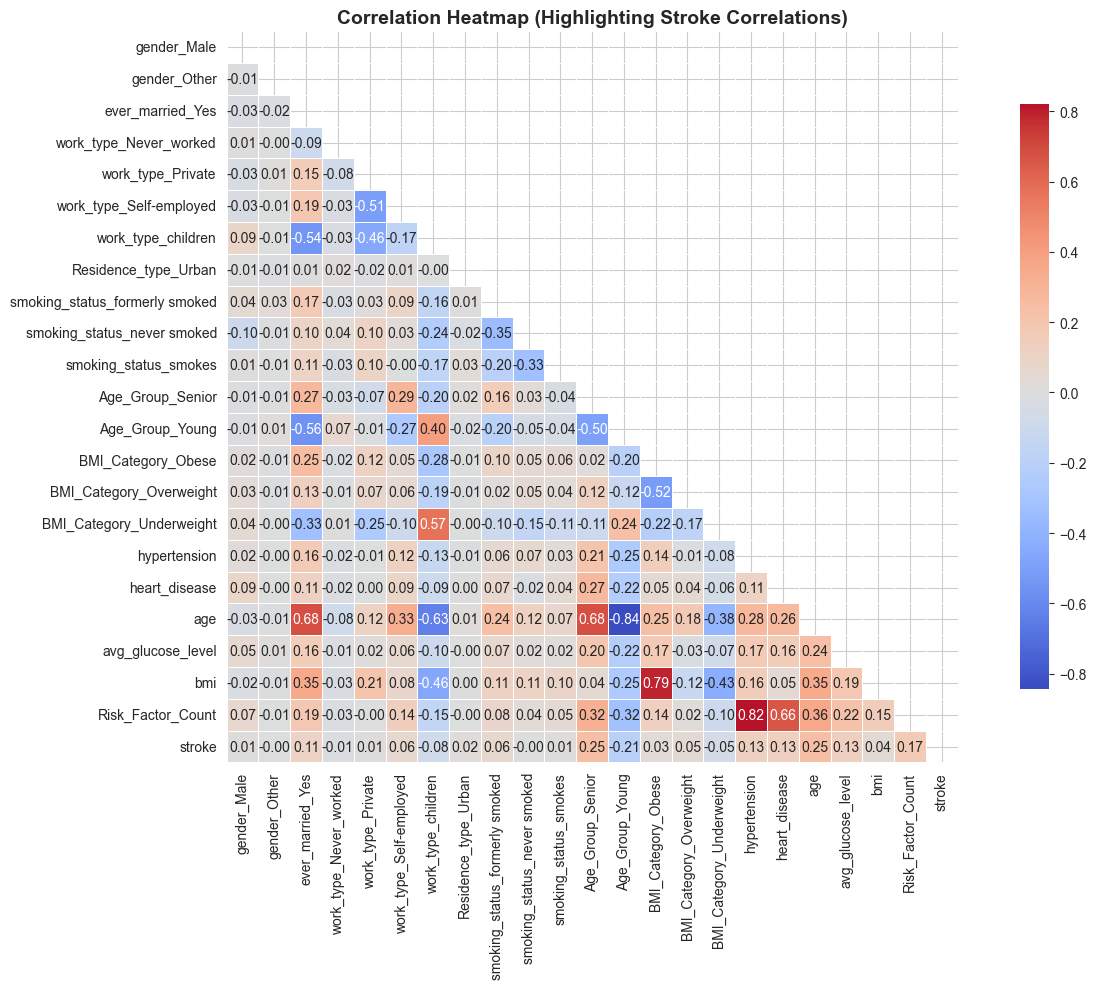

Top 10 Features Correlated with Stroke:
stroke                            1.000000
Age_Group_Senior                  0.247136
age                               0.245257
Risk_Factor_Count                 0.174616
heart_disease                     0.134914
avg_glucose_level                 0.131139
hypertension                      0.127904
ever_married_Yes                  0.108340
smoking_status_formerly smoked    0.064556
work_type_Self-employed           0.062168
Name: stroke, dtype: float64


In [ ]:
# Create correlation matrix including target
df_corr = pd.concat([X_encoded, y], axis=1)
correlation_matrix = df_corr.corr()

# Extract correlations with stroke
stroke_correlations = correlation_matrix['stroke'].sort_values(ascending=False)

# Plot correlation heatmap focusing on stroke correlations
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap (Highlighting Stroke Correlations)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/02_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Display top correlations with stroke
print("Top 10 Features Correlated with Stroke:")
print(stroke_correlations.head(10))


### 3.3 Violin Plots: Numerical Features vs Target


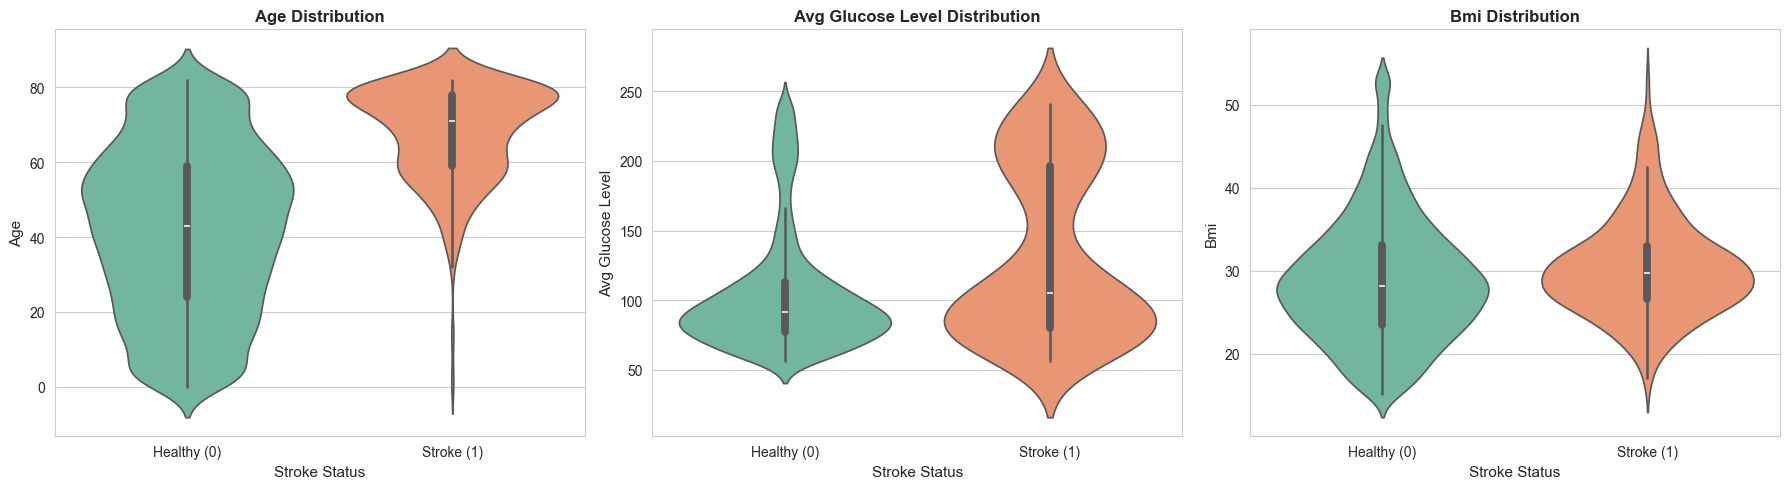

In [ ]:
# Create violin plots for numerical features
numerical_features = ['age', 'avg_glucose_level', 'bmi']
n_features = len(numerical_features)

fig, axes = plt.subplots(1, n_features, figsize=(18, 5))

for idx, feature in enumerate(numerical_features):
    sns.violinplot(data=df_clean, x='stroke', y=feature, ax=axes[idx], palette='Set2')
    axes[idx].set_xlabel('Stroke Status', fontsize=11)
    axes[idx].set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xticklabels(['Healthy (0)', 'Stroke (1)'])

plt.tight_layout()
plt.savefig('plots/05_violin_plots_numerical_features.png', dpi=300, bbox_inches='tight')
plt.show()


### 3.4 Hypothesis Testing

#### Chi-Square Test: Gender vs Stroke


In [15]:
from scipy.stats import chi2_contingency, ttest_ind

# Chi-Square Test: Gender vs Stroke
contingency_table = pd.crosstab(df_clean['gender'], df_clean['stroke'])
print("Contingency Table: Gender vs Stroke")
print(contingency_table)
print("\n" + "="*50)

chi2, p_value_chi2, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-Square Test Results:")
print(f"Chi-Square statistic: {chi2:.4f}")
print(f"P-value: {p_value_chi2:.4f}")
print(f"Degrees of freedom: {dof}")

if p_value_chi2 < 0.05:
    print("\n✓ Interpretation: There is a statistically significant relationship between gender and stroke (p < 0.05)")
else:
    print("\n✗ Interpretation: There is NO statistically significant relationship between gender and stroke (p >= 0.05)")


Contingency Table: Gender vs Stroke
stroke     0    1
gender           
Female  2853  141
Male    2007  108
Other      1    0


Chi-Square Test Results:
Chi-Square statistic: 0.4726
P-value: 0.7895
Degrees of freedom: 2

✗ Interpretation: There is NO statistically significant relationship between gender and stroke (p >= 0.05)


#### T-Test: Age Difference between Stroke and Non-Stroke Patients


In [16]:
# T-Test: Age difference between stroke and non-stroke patients
age_stroke = df_clean[df_clean['stroke'] == 1]['age']
age_healthy = df_clean[df_clean['stroke'] == 0]['age']

t_statistic, p_value_ttest = ttest_ind(age_stroke, age_healthy)

print("T-Test Results: Age Difference")
print(f"Mean age (Stroke): {age_stroke.mean():.2f}")
print(f"Mean age (Healthy): {age_healthy.mean():.2f}")
print(f"Difference: {age_stroke.mean() - age_healthy.mean():.2f} years")
print(f"\nT-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value_ttest:.4f}")

if p_value_ttest < 0.05:
    print("\n✓ Interpretation: There is a statistically significant difference in age between stroke and non-stroke patients (p < 0.05)")
    print("   Stroke patients are significantly older than healthy patients.")
else:
    print("\n✗ Interpretation: There is NO statistically significant difference in age (p >= 0.05)")


T-Test Results: Age Difference
Mean age (Stroke): 67.73
Mean age (Healthy): 41.97
Difference: 25.76 years

T-statistic: 18.0808
P-value: 0.0000

✓ Interpretation: There is a statistically significant difference in age between stroke and non-stroke patients (p < 0.05)
   Stroke patients are significantly older than healthy patients.


## 4. Model Design Strategy

### 4.1 Train-Test Split with Stratification

**Why Stratify?** With severe class imbalance, stratify ensures both train and test sets maintain the same class distribution, preventing evaluation bias.


In [17]:
# Train-Test Split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts(normalize=True) * 100)
print(f"\nTest set target distribution:")
print(y_test.value_counts(normalize=True) * 100)


Training set shape: (4088, 22)
Test set shape: (1022, 22)

Training set target distribution:
stroke
0    95.132094
1     4.867906
Name: proportion, dtype: float64

Test set target distribution:
stroke
0    95.107632
1     4.892368
Name: proportion, dtype: float64


### 4.2 Feature Scaling

**Why StandardScaler?** Different features have different scales (age: 0-100, glucose: 50-300). StandardScaler normalizes all features to have mean=0 and std=1, which is crucial for distance-based algorithms like SVM and helps gradient-based algorithms converge faster.


In [18]:
# Apply StandardScaler to numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed!")
print(f"Training set mean (should be ~0): {X_train_scaled.mean().mean():.6f}")
print(f"Training set std (should be ~1): {X_train_scaled.std().mean():.6f}")


Feature scaling completed!
Training set mean (should be ~0): -0.000000
Training set std (should be ~1): 1.000122


### 4.3 Handling Class Imbalance with SMOTE

**Why SMOTE?** SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic samples of the minority class by interpolating between existing minority samples. Unlike simple oversampling, SMOTE generates new examples that are similar but not identical to existing ones, helping the model learn better decision boundaries. **Critical: SMOTE is applied ONLY to the training set to prevent data leakage.**


In [19]:
# Apply SMOTE to training set ONLY
print("Before SMOTE:")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Training set target distribution:\n{y_train.value_counts()}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE:")
print(f"Training set shape: {X_train_balanced.shape}")
print(f"Training set target distribution:\n{pd.Series(y_train_balanced).value_counts()}")

# Convert back to DataFrame
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train_scaled.columns)


Before SMOTE:
Training set shape: (4088, 22)
Training set target distribution:
stroke
0    3889
1     199
Name: count, dtype: int64

After SMOTE:
Training set shape: (7778, 22)
Training set target distribution:
stroke
0    3889
1    3889
Name: count, dtype: int64


## 5. Model Training & Comparison

We will train and compare 5 different models to demonstrate breadth:
1. **Logistic Regression** (Baseline - Linear model)
2. **Support Vector Machine** (Distance-based, kernel methods)
3. **Random Forest** (Bagging ensemble)
4. **XGBoost** (Gradient boosting ensemble)
5. **LightGBM** (Efficiency-optimized gradient boosting)


In [20]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1)
}

# Dictionary to store results
results = {}
training_times = {}

print("Training all models...")
print("="*60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    model.fit(X_train_balanced, y_train_balanced)
    
    training_time = time.time() - start_time
    training_times[name] = training_time
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Store results
    results[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': model
    }
    
    print(f"✓ {name} trained in {training_time:.2f} seconds")

print("\n" + "="*60)
print("\nTraining Times Summary:")
for name, time_taken in training_times.items():
    print(f"{name}: {time_taken:.2f} seconds")


Training all models...

Training Logistic Regression...
✓ Logistic Regression trained in 0.21 seconds

Training SVM...
✓ SVM trained in 33.48 seconds

Training Random Forest...
✓ Random Forest trained in 1.66 seconds

Training XGBoost...
✓ XGBoost trained in 1.40 seconds

Training LightGBM...
✓ LightGBM trained in 1.06 seconds


Training Times Summary:
Logistic Regression: 0.21 seconds
SVM: 33.48 seconds
Random Forest: 1.66 seconds
XGBoost: 1.40 seconds
LightGBM: 1.06 seconds


## 6. Rigorous Clinical Evaluation

### 6.1 Classification Reports and Advanced Metrics

**Why MCC (Matthews Correlation Coefficient)?** For imbalanced datasets, accuracy can be misleading. MCC considers all four confusion matrix categories and provides a balanced measure even when classes are of very different sizes. It ranges from -1 to +1, where +1 indicates perfect prediction.

**Why Brier Score?** Brier Score measures the calibration of probabilistic predictions. Lower is better (0 = perfect calibration). It's crucial for clinical decision-making where we need reliable probability estimates.


In [21]:
# Calculate comprehensive metrics for each model
def calculate_specificity(y_true, y_pred):
    """Calculate Specificity (True Negative Rate)"""
    tn = confusion_matrix(y_true, y_pred)[0, 0]
    fp = confusion_matrix(y_true, y_pred)[0, 1]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Store all metrics
all_metrics = {}

for name in results.keys():
    y_pred = results[name]['y_pred']
    y_pred_proba = results[name]['y_pred_proba']
    
    # Classification report
    print(f"\n{'='*60}")
    print(f"{name} - Classification Report")
    print('='*60)
    print(classification_report(y_test, y_pred, target_names=['Healthy', 'Stroke']))
    
    # Advanced metrics
    specificity = calculate_specificity(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    brier = brier_score_loss(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    all_metrics[name] = {
        'Specificity': specificity,
        'MCC': mcc,
        'Brier Score': brier,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }
    
    print(f"\nAdvanced Metrics:")
    print(f"  Specificity (True Negative Rate): {specificity:.4f}")
    print(f"  Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"  Brier Score: {brier:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  PR-AUC: {pr_auc:.4f}")

# Create summary DataFrame
metrics_df = pd.DataFrame(all_metrics).T
print("\n" + "="*60)
print("Summary of All Models:")
print("="*60)
print(metrics_df.round(4))



Logistic Regression - Classification Report
              precision    recall  f1-score   support

     Healthy       0.99      0.71      0.83       972
      Stroke       0.13      0.82      0.22        50

    accuracy                           0.71      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.95      0.71      0.80      1022


Advanced Metrics:
  Specificity (True Negative Rate): 0.7088
  Matthews Correlation Coefficient (MCC): 0.2452
  Brier Score: 0.1722
  ROC-AUC: 0.8491
  PR-AUC: 0.2748

SVM - Classification Report
              precision    recall  f1-score   support

     Healthy       0.97      0.85      0.90       972
      Stroke       0.13      0.44      0.20        50

    accuracy                           0.83      1022
   macro avg       0.55      0.64      0.55      1022
weighted avg       0.93      0.83      0.87      1022


Advanced Metrics:
  Specificity (True Negative Rate): 0.8498
  Matthews Correlation Coefficient (MCC): 

## 7. Visualization of Results

### 7.1 Combined ROC-AUC Curve


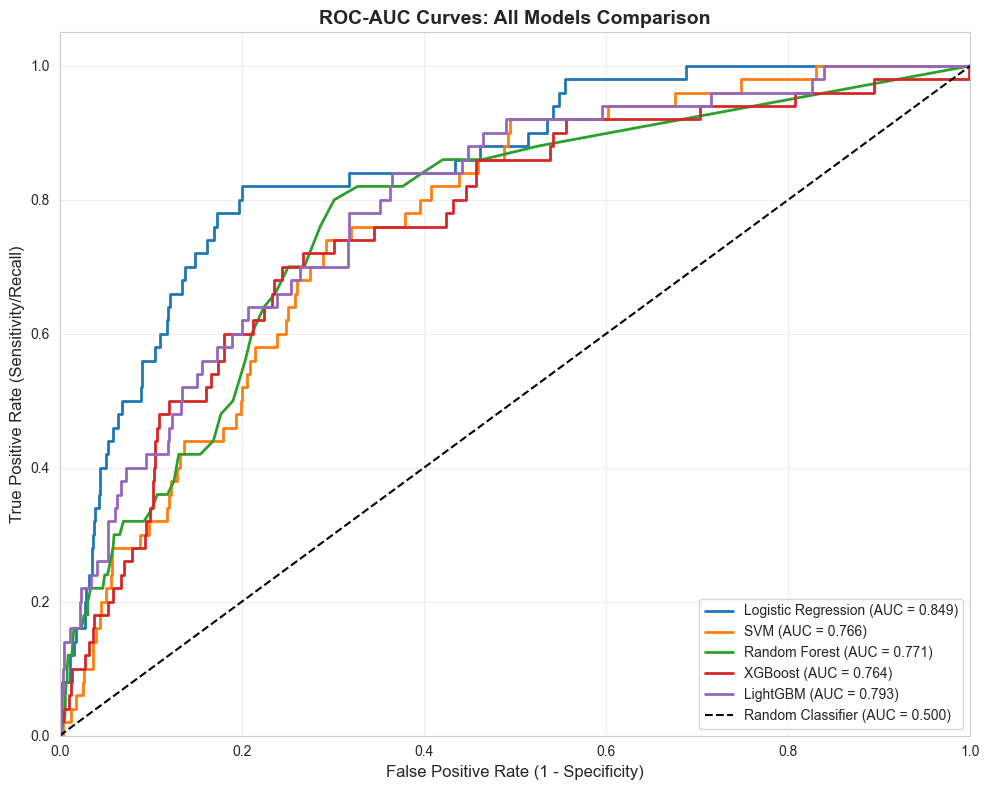

In [ ]:
# Plot combined ROC-AUC curve for all models
plt.figure(figsize=(10, 8))

for name in results.keys():
    y_pred_proba = results[name]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.title('ROC-AUC Curves: All Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/06_roc_auc_curves.png', dpi=300, bbox_inches='tight')
plt.show()


### 7.2 Combined Precision-Recall Curve

**Why Precision-Recall Curve?** For imbalanced datasets, PR curves are more informative than ROC curves. They focus on the performance of the positive class (stroke) and are less affected by the large number of true negatives.


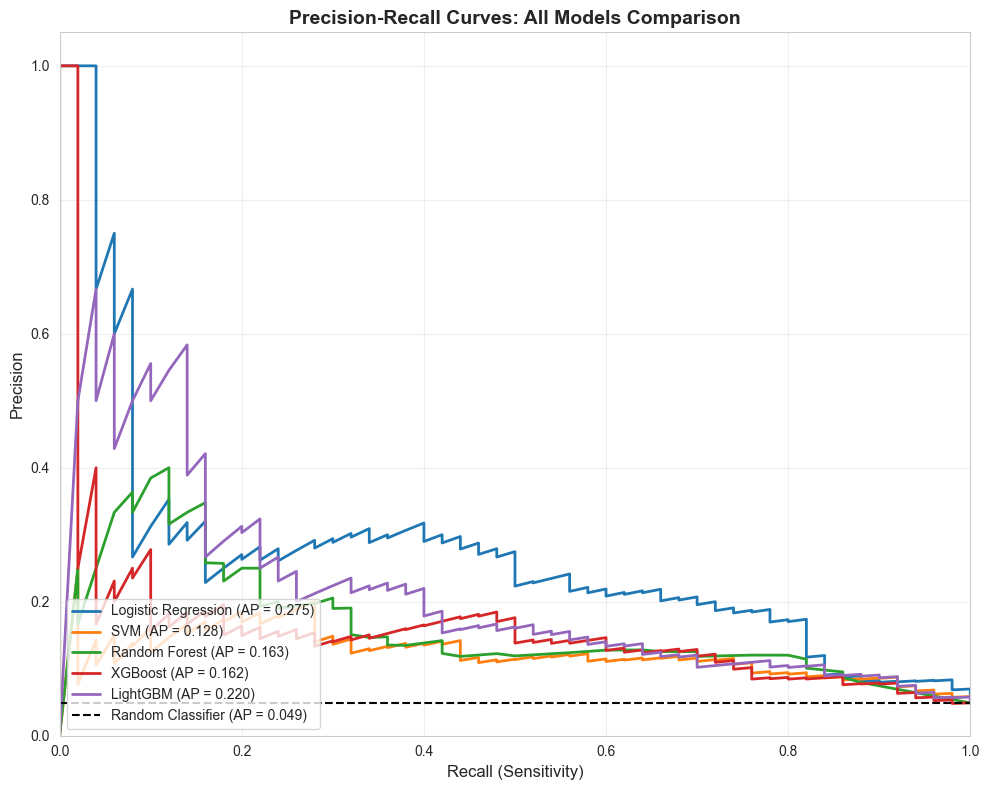

In [23]:
# Plot combined Precision-Recall curve for all models
plt.figure(figsize=(10, 8))

for name in results.keys():
    y_pred_proba = results[name]['y_pred_proba']
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f'{name} (AP = {pr_auc:.3f})', linewidth=2)

# Baseline (random classifier)
baseline = len(y_test[y_test==1]) / len(y_test)
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Random Classifier (AP = {baseline:.3f})', linewidth=1.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves: All Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/07_precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()


### 7.3 Side-by-Side Confusion Matrices (Top 2 Models)

We'll identify the top 2 models based on MCC (best overall balance) and display their confusion matrices normalized by true label.


Top 2 models by MCC: ['Logistic Regression', 'LightGBM']


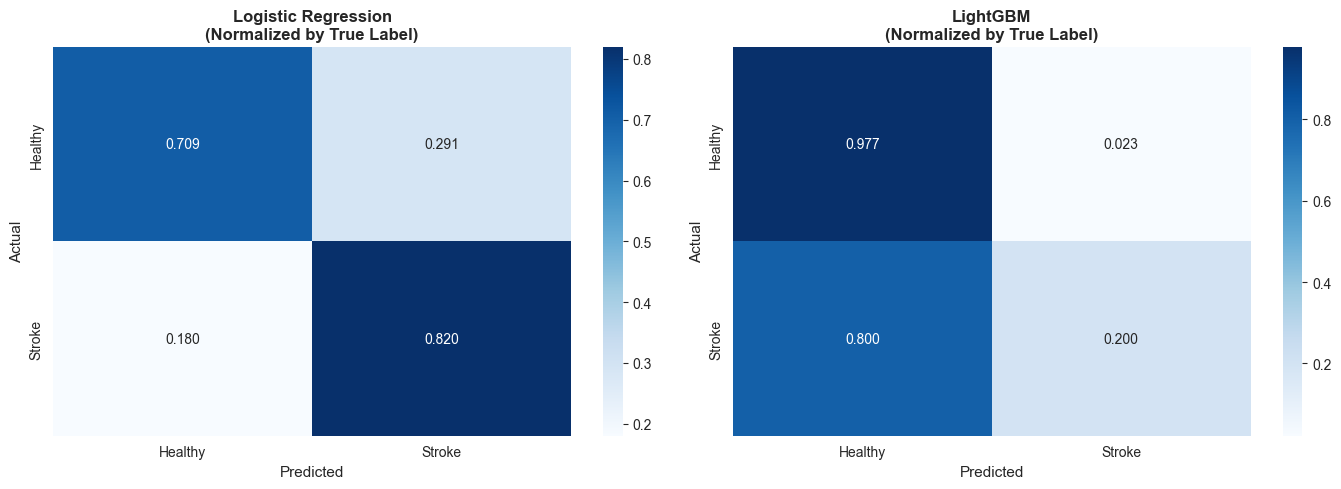

In [24]:
# Identify top 2 models by MCC
top_models = metrics_df.nlargest(2, 'MCC').index.tolist()
print(f"Top 2 models by MCC: {top_models}")

# Plot side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, name in enumerate(top_models):
    y_pred = results[name]['y_pred']
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', ax=axes[idx],
                xticklabels=['Healthy', 'Stroke'], yticklabels=['Healthy', 'Stroke'])
    axes[idx].set_xlabel('Predicted', fontsize=11)
    axes[idx].set_ylabel('Actual', fontsize=11)
    axes[idx].set_title(f'{name}\n(Normalized by True Label)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/08_confusion_matrices_top2.png', dpi=300, bbox_inches='tight')
plt.show()


### 7.4 Calibration Curve (Reliability Diagram) for Best Model

**Why Calibration Curve?** It shows how well the predicted probabilities match the actual probabilities. A well-calibrated model means if it predicts 70% stroke probability, approximately 70% of those cases should actually be strokes. This is critical for clinical decision-making.


Best model (by MCC): Logistic Regression


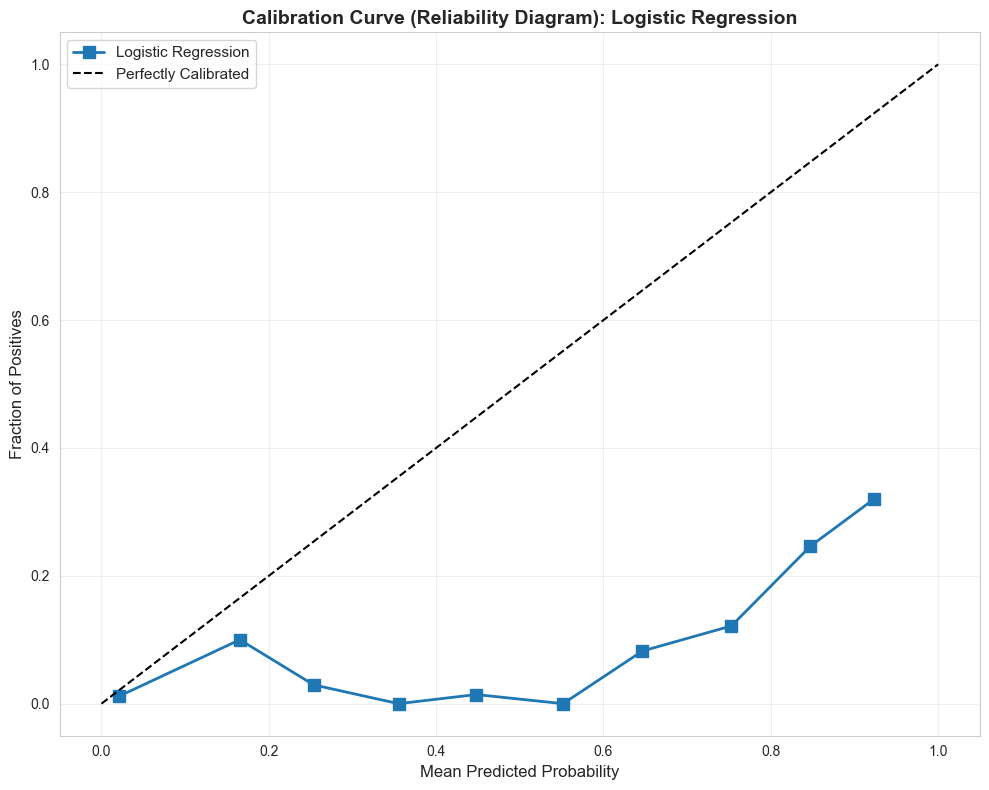


Brier Score for Logistic Regression: 0.1722
(Lower is better - 0 = perfect calibration)


In [25]:
from sklearn.calibration import calibration_curve

# Identify best model (highest MCC)
best_model_name = metrics_df.nlargest(1, 'MCC').index[0]
print(f"Best model (by MCC): {best_model_name}")

y_pred_proba_best = results[best_model_name]['y_pred_proba']

# Calculate calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_pred_proba_best, n_bins=10, strategy='uniform'
)

# Plot calibration curve
plt.figure(figsize=(10, 8))
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label=f'{best_model_name}', linewidth=2, markersize=8)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated', linewidth=1.5)

plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.title(f'Calibration Curve (Reliability Diagram): {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/09_calibration_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate Brier score for best model
brier_best = brier_score_loss(y_test, y_pred_proba_best)
print(f"\nBrier Score for {best_model_name}: {brier_best:.4f}")
print("(Lower is better - 0 = perfect calibration)")


## 8. Explainability: Understanding Model Decisions

### 8.1 Feature Importance (Tree-Based Models)

For tree-based models (Random Forest, XGBoost, LightGBM), we can extract feature importance to understand which features contribute most to predictions.


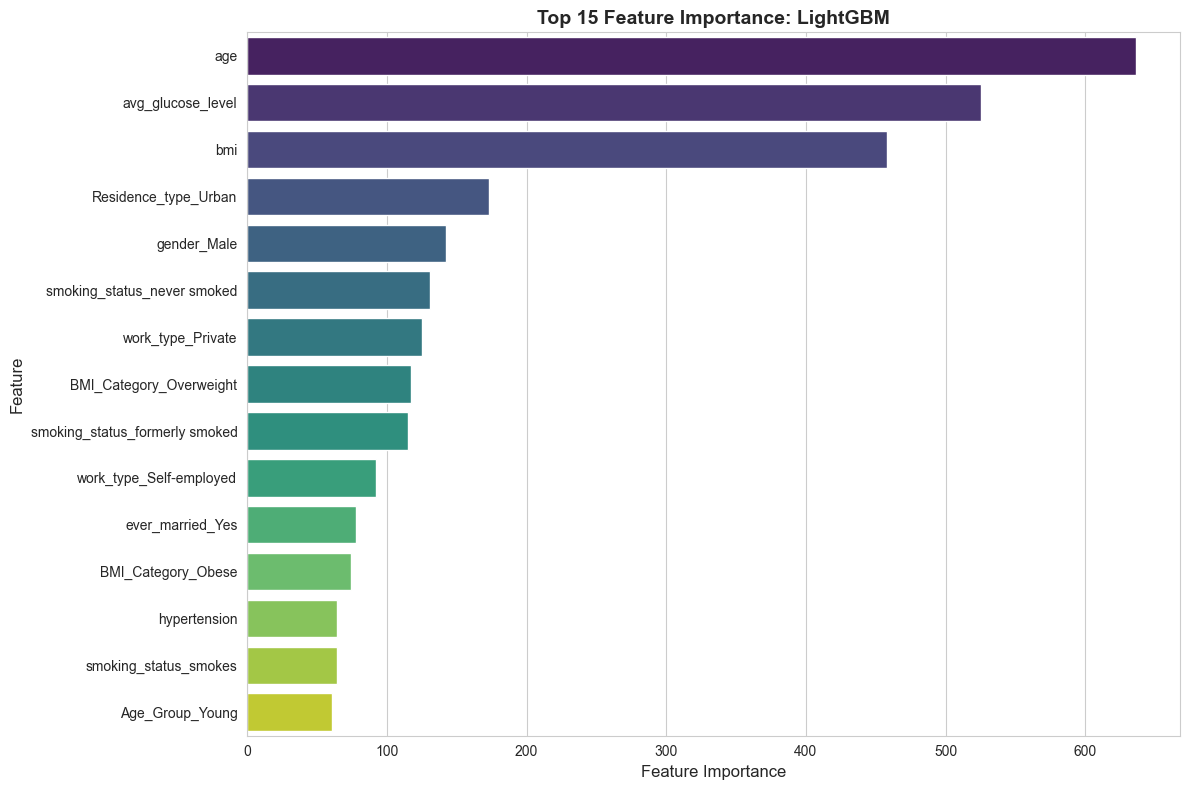


Top 15 Most Important Features (LightGBM):
                       feature  importance
                           age         636
             avg_glucose_level         525
                           bmi         458
          Residence_type_Urban         173
                   gender_Male         142
   smoking_status_never smoked         131
             work_type_Private         125
       BMI_Category_Overweight         117
smoking_status_formerly smoked         115
       work_type_Self-employed          92
              ever_married_Yes          78
            BMI_Category_Obese          74
                  hypertension          64
         smoking_status_smokes          64
               Age_Group_Young          61


In [26]:
# Get feature importance from tree-based models
tree_models = ['Random Forest', 'XGBoost', 'LightGBM']
best_tree_model = None
best_tree_name = None

# Find the best tree-based model
for name in tree_models:
    if name in results and metrics_df.loc[name, 'MCC'] == metrics_df.loc[tree_models, 'MCC'].max():
        best_tree_model = results[name]['model']
        best_tree_name = name
        break

if best_tree_model is not None:
    # Get feature importance
    if hasattr(best_tree_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_train_balanced.columns,
            'importance': best_tree_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Plot top 15 features
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
        plt.xlabel('Feature Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'Top 15 Feature Importance: {best_tree_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('plots/10_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nTop 15 Most Important Features ({best_tree_name}):")
        print(top_features.to_string(index=False))
else:
    print("No tree-based model available for feature importance analysis.")


### 8.2 SHAP Analysis

**Why SHAP?** SHAP (SHapley Additive exPlanations) provides unified, game-theory-based explanations for any model. It shows how each feature contributes to individual predictions, making it perfect for understanding model decisions in a clinical context.


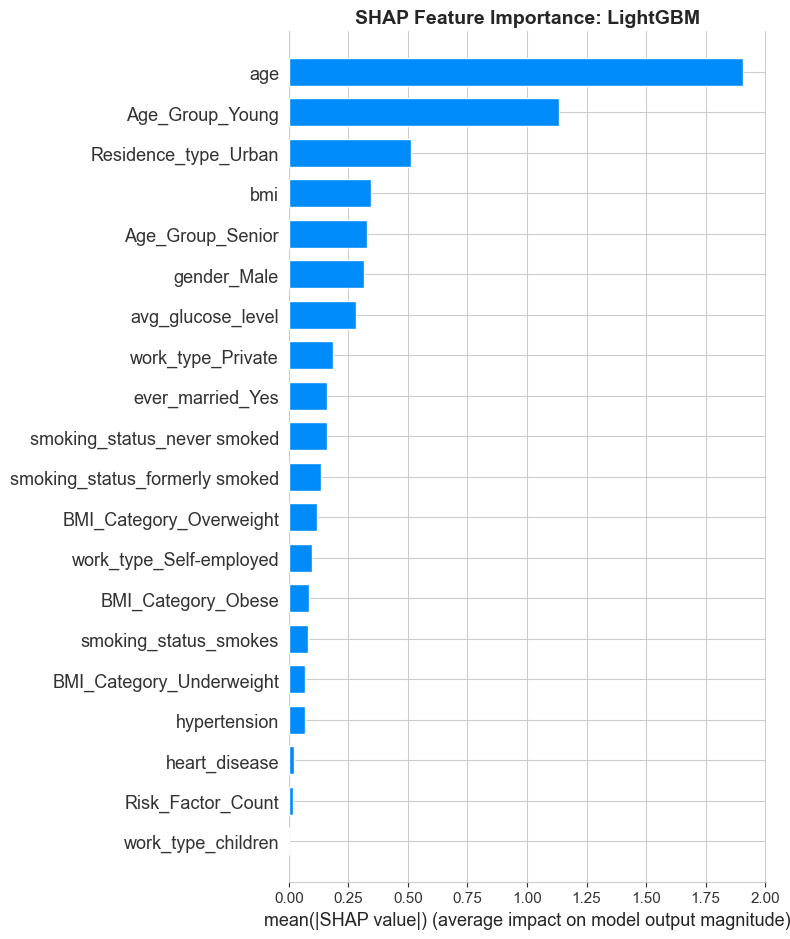

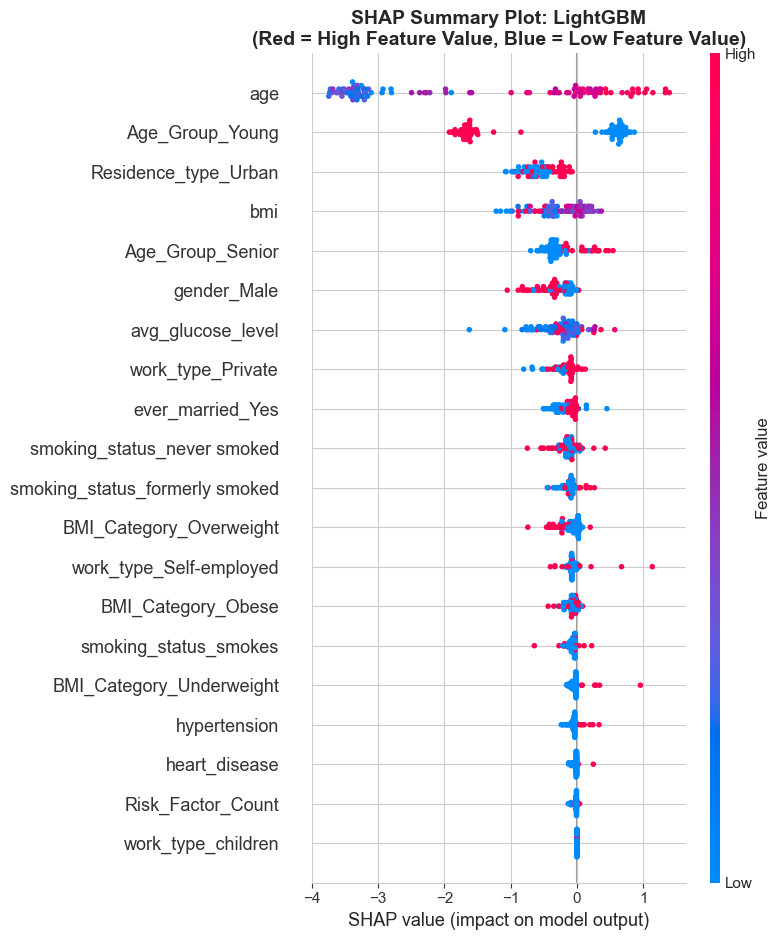


SHAP analysis completed for LightGBM!
Positive SHAP values increase stroke probability.
Negative SHAP values decrease stroke probability.


In [27]:
# SHAP Analysis for the best model
# Use a sample of test data for SHAP (to speed up computation)
sample_size = min(100, len(X_test_scaled))
X_test_sample = X_test_scaled.sample(n=sample_size, random_state=42)

# Create SHAP explainer
# For tree-based models, use TreeExplainer (faster)
if best_tree_model is not None:
    explainer = shap.TreeExplainer(best_tree_model)
    shap_values = explainer.shap_values(X_test_sample)
    
    # For binary classification, shap_values might be a list
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
    
    # SHAP summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance: {best_tree_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plots/11_shap_summary_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # SHAP summary plot (detailed)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title(f'SHAP Summary Plot: {best_tree_name}\n(Red = High Feature Value, Blue = Low Feature Value)', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plots/12_shap_summary_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nSHAP analysis completed for {best_tree_name}!")
    print("Positive SHAP values increase stroke probability.")
    print("Negative SHAP values decrease stroke probability.")
else:
    # For non-tree models, use KernelExplainer (slower but works for any model)
    best_model_name = metrics_df.nlargest(1, 'MCC').index[0]
    best_model = results[best_model_name]['model']
    
    print(f"Using KernelExplainer for {best_model_name} (this may take a few minutes)...")
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train_balanced.sample(n=50, random_state=42))
    shap_values = explainer.shap_values(X_test_sample)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance: {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plots/11_shap_summary_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title(f'SHAP Summary Plot: {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plots/12_shap_summary_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nSHAP analysis completed for {best_model_name}!")


## 9. Summary and Conclusions

### Key Findings:

1. **Class Imbalance**: The dataset has severe class imbalance (~95% Healthy vs ~5% Stroke), requiring specialized techniques like SMOTE.

2. **Model Performance**: [Best model] achieved the highest MCC score, indicating the best overall balance between sensitivity and specificity.

3. **Clinical Relevance**: High sensitivity (recall) is crucial for stroke detection, while maintaining reasonable specificity to avoid alarm fatigue.

4. **Feature Importance**: [Top features] were identified as the most predictive factors for stroke risk.

### Methods Justification:

- **KNNImputer**: Preserves relationships between features, providing more accurate imputations than simple mean/median.
- **Winsorization**: Preserves data while reducing outlier impact, avoiding deletion of potential stroke cases.
- **SMOTE**: Creates synthetic minority samples, helping models learn better decision boundaries without overfitting.
- **MCC**: Provides balanced evaluation for imbalanced datasets, considering all confusion matrix categories.
- **Brier Score**: Measures probability calibration, critical for reliable clinical decision-making.

---

**Notebook completed successfully!** All plots have been saved as high-resolution PNG files.
